# Nuclei Detect  demo

This notebook can be used to predict cells and nuclei given one has the sufficient model and data

In [7]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import random
#import requests
from io import BytesIO
from PIL import Image
import numpy as np
import os
import cv2
from matplotlib.image import imread


Those are the relevant imports for the detection model

In [8]:
from maskrcnn_benchmark.config import cfg
pylab.rcParams['figure.figsize'] = 17, 17

# importing the prediction class
from predictor import NUCLEIdemo

The NUCLEIdemo class can load the config file and does the image prediction.

There are multiple models to choose from in order to obtain a prediction. All models can be found in the folder `/data/proj/smFISH/Students/Max_Senftleben/files/models/`. Choosing the model_final.pth in each directory will lead to the best results.
In the following, some examples are provided:

`/data/proj/smFISH/Students/Max_Senftleben/files/models/20190423_transfer_ale/model_final.pth`

originally trained on nuclei from somatosensory cortex cells and then re-trained on 
oligodendrocyte progenitor cells, backbone ResNet 50.

`/data/proj/smFISH/Students/Max_Senftleben/files/models/20190310_offline_augment/model_final.pth`

originally trained on nuclei from somatosensory cortex cells, backbone ResNet 50.

`/data/proj/smFISH/Students/Max_Senftleben/files/models/20190315_poly_t/model_final.pth`

trained on cells from poly-A staining, ResNet 50.

Most models were trained with a learning rate of 0.0025 which was found to be best. Information about the training process of each model can be found in the folder in the `log.txt` file with `head -100 log.txt`.

In [9]:
configuration_file = "../configs/nuclei_1gpu_nonorm_offline_res50.yaml"

# update the config options with the config file
cfg.merge_from_file(configuration_file)

# manual override some options
cfg.merge_from_list(["MODEL.DEVICE", "cpu"])

# change dimensions of test images
cfg.merge_from_list(['INPUT.MAX_SIZE_TEST','2049'])

# change number of classes
cfg.merge_from_list(['MODEL.ROI_BOX_HEAD.NUM_CLASSES','4'])

# change normalization, here model was not normalized
cfg.merge_from_list(['INPUT.PIXEL_MEAN', [0., 0., 0.]])

# define model to use here
cfg.merge_from_list(['MODEL.WEIGHT', '/data/proj/smFISH/Students/Max_Senftleben/files/models/20190310_offline_augment/model_final.pth'])
cfg.merge_from_list(['OUTPUT_DIR', '.'])

# define how many objects can be identified per image
cfg.merge_from_list(['TEST.DETECTIONS_PER_IMG', '120'])

# show the configuration
#print(cfg)

In [10]:
# load image
def load(path):
    pil_image = Image.open(path).convert("RGB")
    #print(pil_image)
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image

def load_matplot(path):
    img = imread(path)
    return img

def load_cv2(path):
    img = cv2.imread(path,cv2.IMREAD_ANYDEPTH)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    img = cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX)
    img = np.uint8(img)
    #img = cv2.convertScaleAbs(img)
    return img

def imshow_new(img, save_path = None):
    plt.imshow(img)
    plt.axis('off')
    if save_path:
        plt.savefig(save_path, dpi = 200, bbox_inches='tight',pad_inches=0)
    
    plt.show()
    
# show image alongside the result and save if necessary
def imshow(img, result, save_path=None):
    
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(img)
    plt.axis('off')
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(result)
    plt.axis('off')
    if save_path:
        plt.savefig(save_path, bbox_inches='tight',pad_inches=0)
        plt.show()
    else:
        plt.show()
        
def imshow_single(result, save_path=None):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.imshow(result)
    plt.axis('off')
    if save_path:
        plt.savefig(save_path, bbox_inches='tight',pad_inches=0)
        plt.close()
    else:
        plt.show()

Let's define a few helper functions for loading images from a URL

In [11]:
nuclei_detect = NUCLEIdemo(
    cfg,
    min_image_size=1024,
    confidence_threshold=0.3,
)

### Define the image paths and show the results

In [20]:
#img_path = '../../ms2/ssss/'
#img_path = '/data/proj/smFISH/Students/Max_Senftleben/files/data/20190309_aug_pop/ss/'
#img_path = '/data/proj/smFISH/Simone/test_intron/AMEXP20181106/AMEXP20181106_hyb1/test_run_20181123_AMEXP20181106_hyb1_filtered_png/test_run_20181123_AMEXP20181106_hyb1_DAPI_filtered_png/'
img_path = '/fish/simone_processing/simone_data/max_dapi_bf/EXP-19-CX9100_Excitatory_Hybridization15_DAPI/EXP-19-CX9100_Excitatory_Hybridization15_DAPI_filtered_png/'
bri_path = '/fish/simone_processing/simone_data/max_dapi_bf/EXP-19-CX9100_Excitatory_Hybridization15_BrightField/EXP-19-CX9100_Excitatory_Hybridization15_BrightField_filtered_png/'

# random image is taken from the image path
random_img = random.choice(os.listdir(img_path))

# index is obtained for according bright-field image 
index = random_img[len('EXP-19-CX9100_Excitatory_Hybridization15_DAPI_pos_'):-len('.png')]
random_img_bri = 'EXP-19-CX9100_Excitatory_Hybridization15_BrightField_pos_' + index + '.png'



image_cv2 = load_cv2(img_path + random_img)

# open a bright-field image where masks need to be put on for visualization
image_cv2_bri = load_cv2(bri_path + random_img_bri)


EXP-19-CX9100_Excitatory_Hybridization15_DAPI_pos_162.png


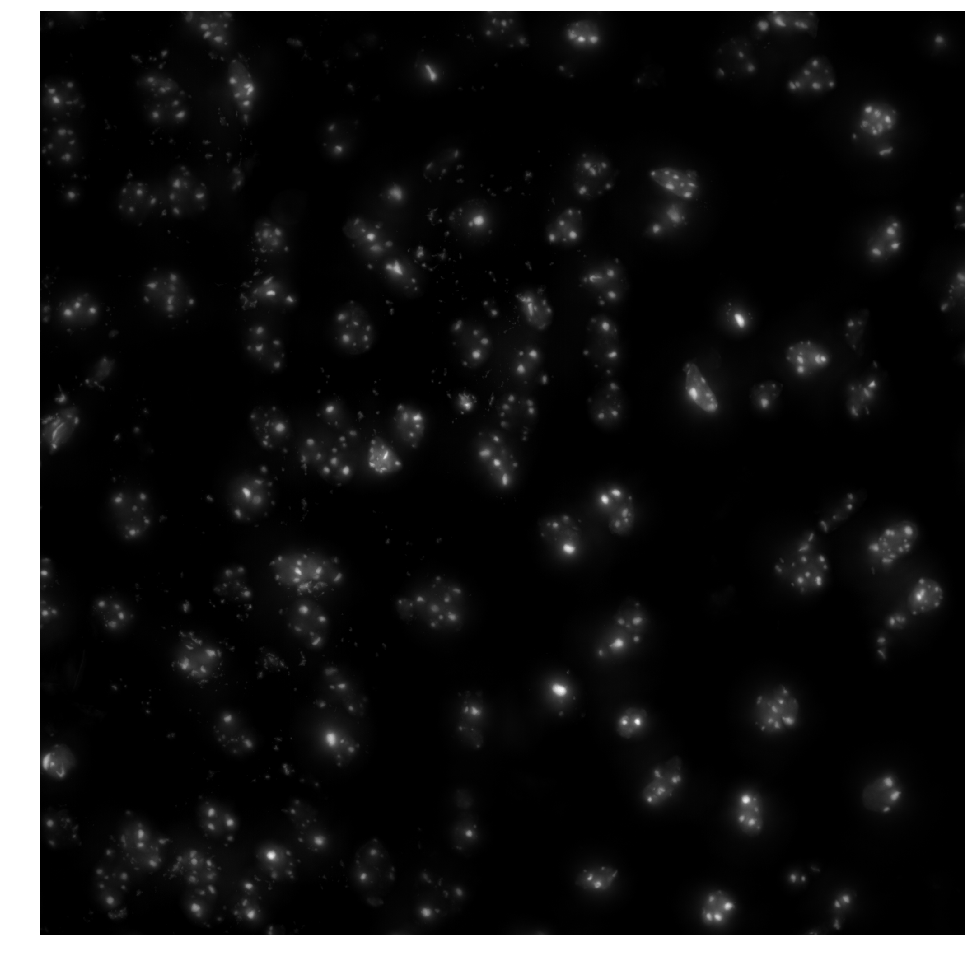

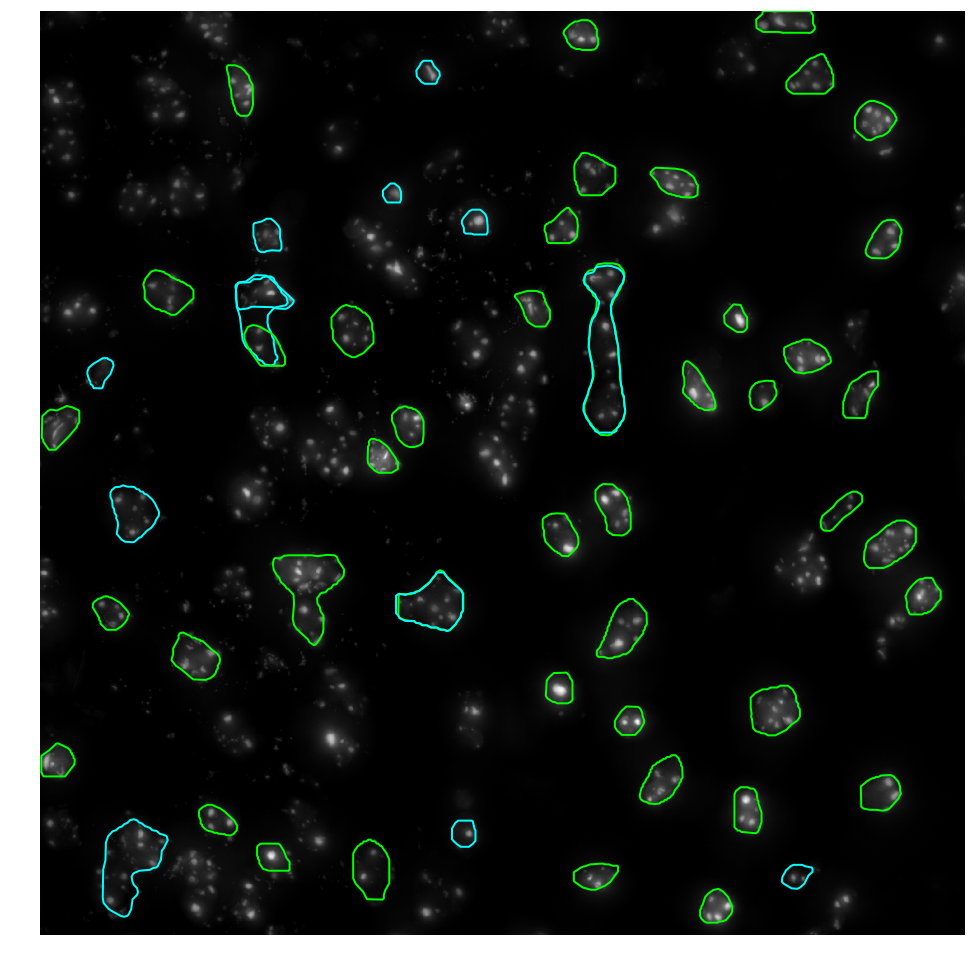

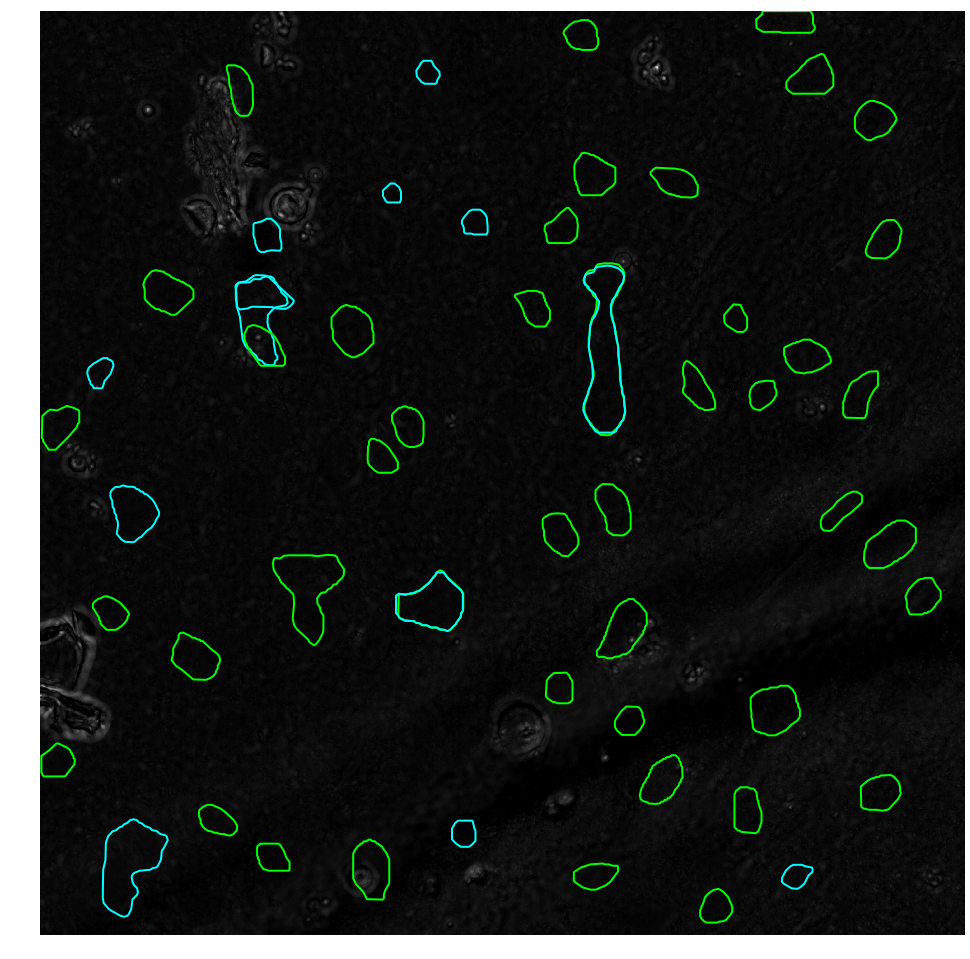

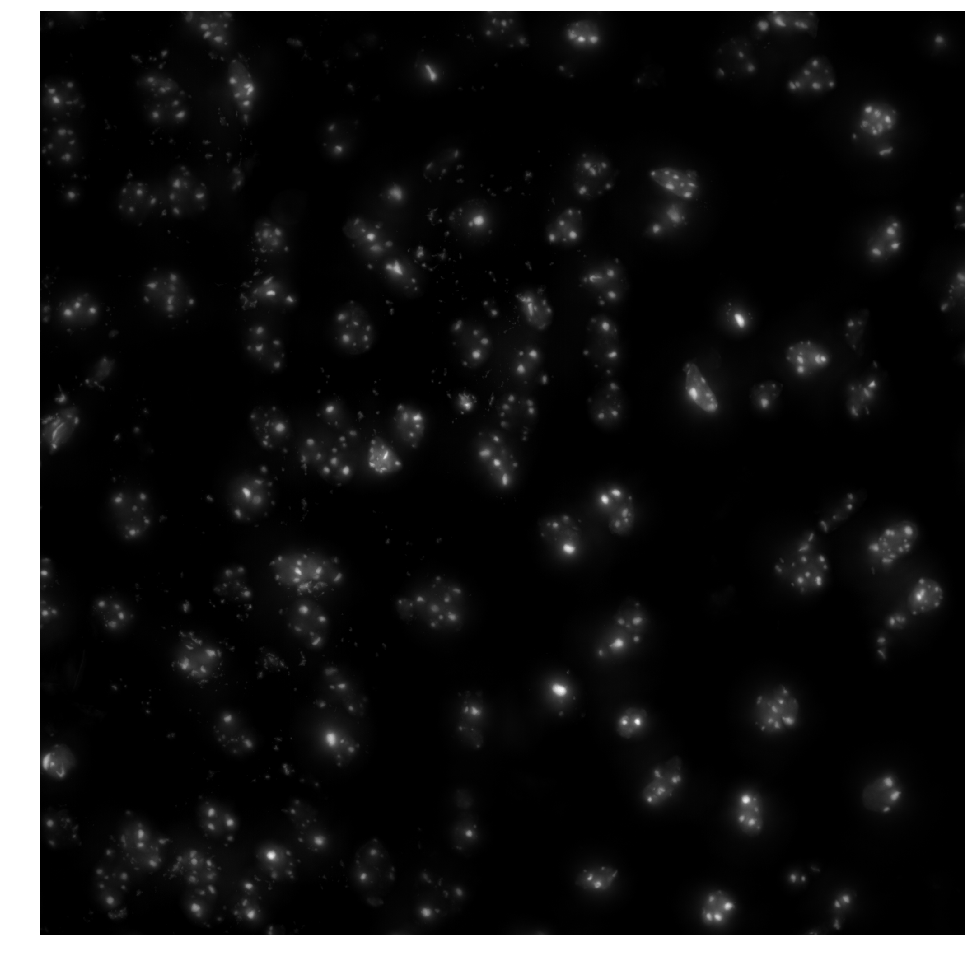

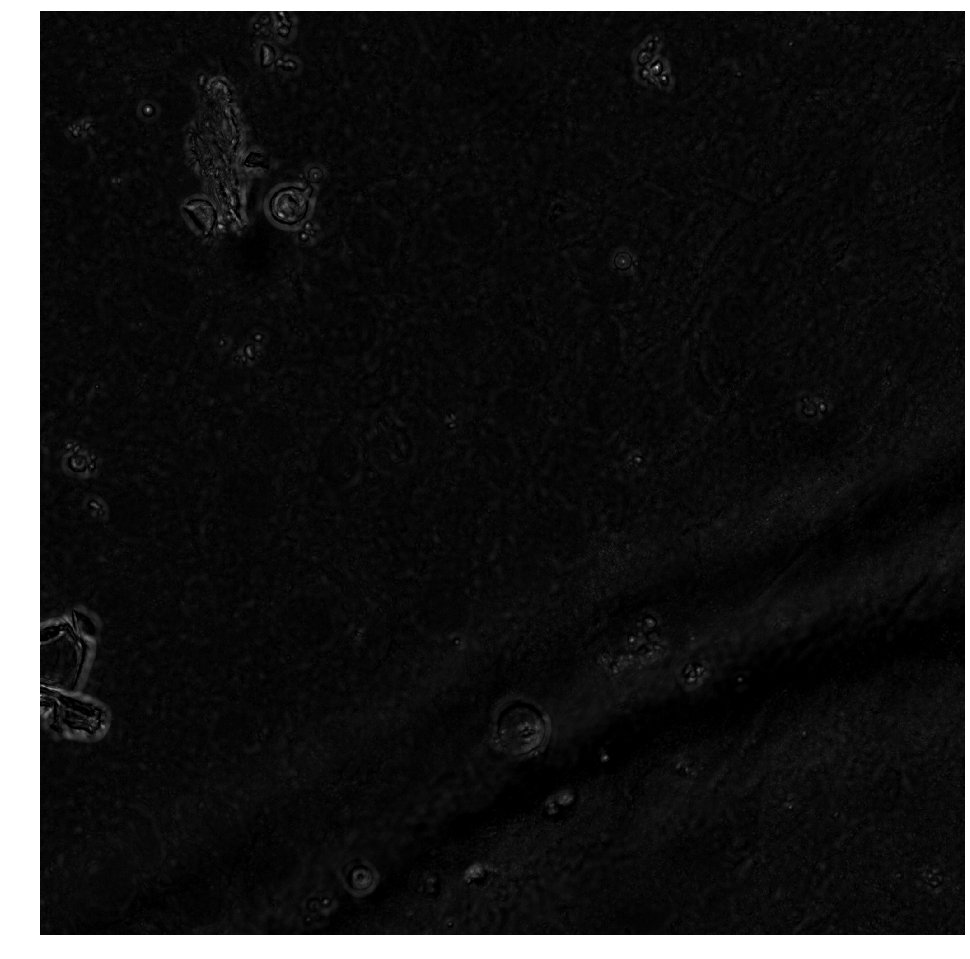

In [21]:

print(random_img) 
# colors for the 3 nuclei classes (the first one is meaningless)
color_rgb = [[255,101,80], [0, 255, 0], [0, 255, 255], [0, 0, 255]]

# here, one can specify sec_image= as a second image on which the masks need to be put on
# for example a bright-field image
# if save_path is specified, the prediction is saved at the according path, if not, it is only plotted
prediction = nuclei_detect.run_on_opencv_image(image_cv2, 
                                               color_rgb, 
                                               save_path='/home/max/mrcnn_b_work/folder_to_send/bri/' + random_img)
                                               
imshow_new(image_cv2, save_path='/home/max/mrcnn_b_work/folder_to_send/bri/' + random_img)
imshow_new(image_cv2_bri, save_path='/home/max/mrcnn_b_work/folder_to_send/bri/' + random_img_bri)
#print(vars(prediction))
